# Analyze Optical Transmission of Oatmilk

## Import modules

In [1]:
from os import path
import glob
import re
import ast
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn import preprocessing

## Load data

In [2]:
# Define paths to data and find files matching the file name pattern
LISST_PATH = "C:/Users/kylene.cooley/Documents/prtsz_bench_test"
DATA_PATH = "oatmilk-*[0-9]percent.csv"

flist = glob.glob(DATA_PATH, root_dir=LISST_PATH, recursive=True)

In [3]:
# Define functions
def load_lisst(fpath, csvhdr):
    # Load processed LISST data
    lisst_data = pd.read_csv(fpath, names=csvhdr)
    try: lisst_data.head(1) 
    except: print("No LISST data found.")
    # Create LISST time vectors for Xarray Dataset coordinates
    lisst_time = pd.to_datetime(lisst_data[["year", "month", "day", "hour", "minute", "second"]], yearfirst=True, utc=True)
    lisst_data.insert(0, "time", lisst_time.values)
    lisst_data.set_index("time", drop=True, inplace=True)
    # print(lisst_data.head(1))
    # Convert data frames to xarray for easy manipulation
    lisst_ds = xr.Dataset.from_dataframe(lisst_data)
    # Create 2D array for binned volume concentration
    volumecon2D = list([])
    bins = list([])
    for var in lisst_ds.variables:
        if re.search("volumecon[0-9]+", var):
                bins.append(var)
                volumecon2D.append(lisst_ds[var])
    lisst_ds = lisst_ds.drop_vars(bins)
    str2num = lambda x: int(x.replace("volumecon", ""))
    bins = [str2num(x) for x in bins]
    lisst_ds["volume_concentration_2D"] = xr.concat(
        volumecon2D, pd.Index(bins, name="bin")
        )
    lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")
    return lisst_ds

<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_79400\2393365185.py:27: SyntaxWarning: invalid escape sequence '\m'
  lisst_ds["volume_concentration_2D"] = lisst_ds["volume_concentration_2D"].assign_attrs(units="$\mu$L/L")


In [4]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]

In [ ]:
# Change first 36 column names to integer bin numbers
# bins = np.arange(36)+1
# csvhdr[0:36] = bins.astype(str)
# csvhdr

In [5]:
# Load data to workspace
lisst0017 = load_lisst(path.join(LISST_PATH, flist[0]), csvhdr)
lisst0366 = load_lisst(path.join(LISST_PATH, flist[1]), csvhdr)
lisst0776 = load_lisst(path.join(LISST_PATH, flist[2]), csvhdr)
lisst1240 = load_lisst(path.join(LISST_PATH, flist[3]), csvhdr)
lisst1776 = load_lisst(path.join(LISST_PATH, flist[4]), csvhdr)
lisst2409 = load_lisst(path.join(LISST_PATH, flist[5]), csvhdr)
lisst3185 = load_lisst(path.join(LISST_PATH, flist[6]), csvhdr)
lisst4185 = load_lisst(path.join(LISST_PATH, flist[7]), csvhdr)

## Statistical summary of results

In [6]:
# Target percent oatmilk concentrations
oatmilk_percent = np.array([0.0017, 0.0366, 0.0776, 0.1240,
                            0.1776, 0.2409, 0.3185, 0.4185])

In [7]:
# Mean optical transmission
optical_transmission_avg = np.array([lisst0017.optical_transmission.mean(), lisst0366.optical_transmission.mean(),
       lisst0776.optical_transmission.mean(), lisst1240.optical_transmission.mean(),
       lisst1776.optical_transmission.mean(), lisst2409.optical_transmission.mean(),
       lisst3185.optical_transmission.mean(), lisst4185.optical_transmission.mean()])*100
print(optical_transmission_avg)

[98.68462377 85.83917869 78.43772894 67.24548105 58.15783582 45.98713568
 28.65245365 21.23235592]


In [8]:
# Mean total volume concentration
total_volume_avg = np.array([lisst0017.total_volumecon.mean(), lisst0366.total_volumecon.mean(),
       lisst0776.total_volumecon.mean(), lisst1240.total_volumecon.mean(),
       lisst1776.total_volumecon.mean(), lisst2409.total_volumecon.mean(),
       lisst3185.total_volumecon.mean(), lisst4185.total_volumecon.mean()])
print(total_volume_avg)

[  2.24182345  15.87799145  13.02738254  21.4840809   30.80565728
  77.16768824 141.67419062 126.61629525]


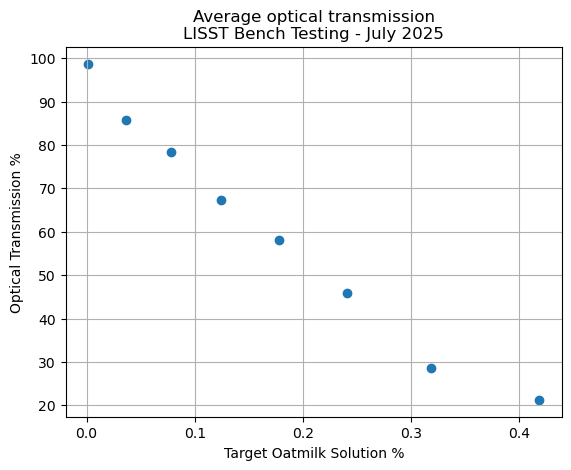

In [9]:
# Plot avg optical transmission 
fig0, ax0 = plt.subplots()
ax0.scatter(oatmilk_percent, optical_transmission_avg)
ax0.set_xlabel("Target Oatmilk Solution %")
ax0.set_ylabel("Optical Transmission %")
plt.title("Average optical transmission\nLISST Bench Testing - July 2025")
ax0.grid()

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_79400\911406187.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("Total Volume Concentration [$\mu$L/L]")


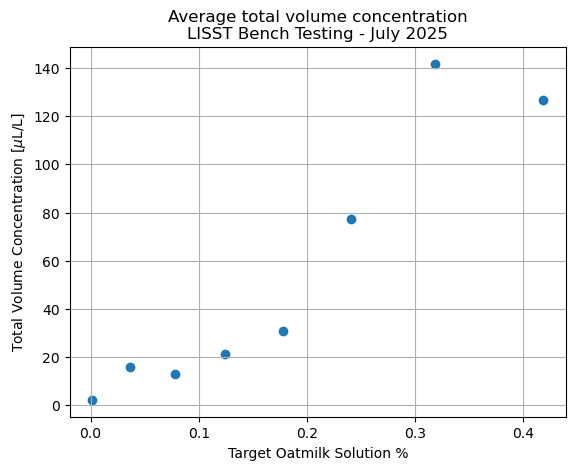

In [10]:
# Plot avg total volume concentration
fig1, ax1 = plt.subplots()
ax1.scatter(oatmilk_percent, total_volume_avg)
ax1.set_xlabel("Target Oatmilk Solution %")
ax1.set_ylabel("Total Volume Concentration [$\mu$L/L]")
plt.title("Average total volume concentration\nLISST Bench Testing - July 2025")
ax1.grid()

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_79400\3737671982.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax01_twin.set_ylabel("Total Volume Concentration [$\mu$L/L]", color="red")


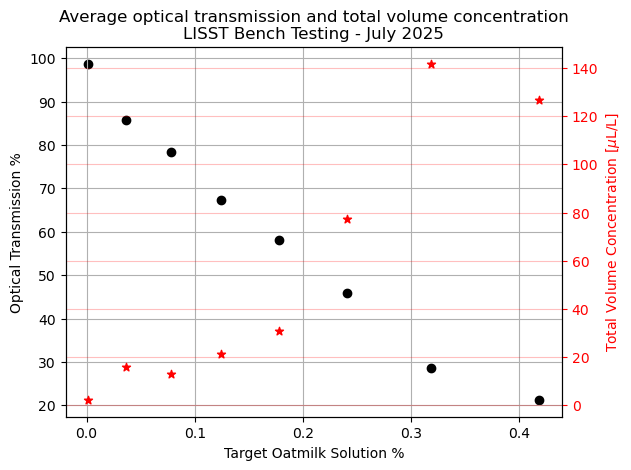

In [22]:
# Combine the average optical transmission and average
# total volume concentration plots above
fig01, ax01 = plt.subplots()
ax01.scatter(oatmilk_percent, optical_transmission_avg, color="black")
ax01.set_xlabel("Target Oatmilk Solution %")
ax01.set_ylabel("Optical Transmission %")
# Create twin axes that share x-axis
ax01_twin = ax01.twinx()
ax01_twin.scatter(oatmilk_percent, total_volume_avg, color="red", marker="*")
ax01_twin.set_ylabel("Total Volume Concentration [$\mu$L/L]", color="red")
ax01_twin.yaxis.set_tick_params(color="red", labelcolor="red")

plt.title("Average optical transmission and total volume concentration\nLISST Bench Testing - July 2025")
ax01.grid()
ax01_twin.grid(color="red", alpha=0.25)

Text(0.5, 1.0, 'Optical Transmission in Oatmilk Solutions')

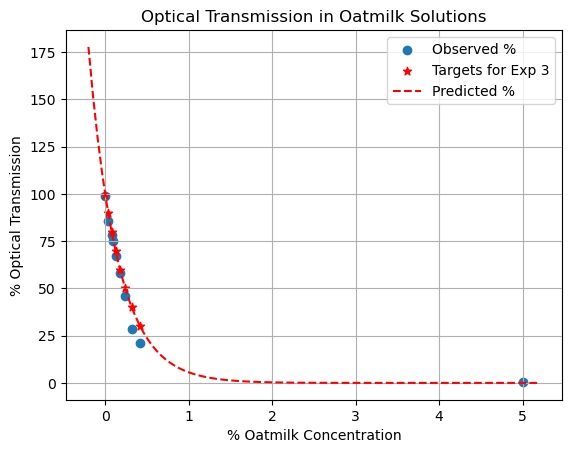

In [23]:
# Compare results with predicted optical transmission
# Append original data points to observations
oatmilk = np.append(oatmilk_percent, [0.1, 5])
transmission = np.append(optical_transmission_avg, [75, 0.5])
goal_transmit = np.array([99.5, 90, 80, 70, 60, 50, 40, 30])

# Predicted exponential relationship of form y = a*e^kx
# The expressions for a and k were solved manually
# from the points (0.1, 75) and (0, 100).
a = 100
k = (-1/0.1)*np.log(3/4)
# Find target oatmilk concentrations for target optical transmission
goal_milk = (-1/k)*np.log((goal_transmit/a))

# find y for x in [-0.2, 5]
x = np.linspace(-0.2, 5.2, 100)
y = a*np.exp((-k*x))

fig2, ax2 = plt.subplots()
plt.scatter(oatmilk, transmission, label="Observed %")
plt.scatter(goal_milk, goal_transmit, marker="*", c="r", label="Targets for Exp 3")
plt.plot(x, y, "r--", label="Predicted %")
ax2.set_xlabel("% Oatmilk Concentration")
ax2.set_ylabel("% Optical Transmission")
ax2.grid()
plt.legend()
plt.title("Optical Transmission in Oatmilk Solutions")

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_79400\2442413933.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax3.set_ylabel("Volume Concentration [$\mu$L/L]")


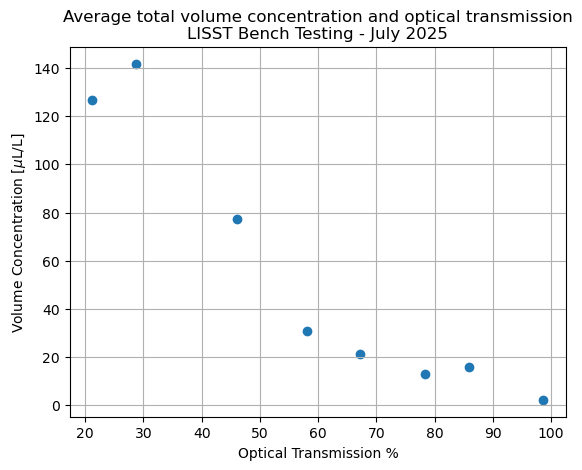

In [24]:
# Plot avg optical transmission against
# avg total volume concentration
fig3, ax3 = plt.subplots()
ax3.scatter(optical_transmission_avg, total_volume_avg)
ax3.set_xlabel("Optical Transmission %")
ax3.set_ylabel("Volume Concentration [$\mu$L/L]")
plt.title("Average total volume concentration and optical transmission\nLISST Bench Testing - July 2025")
ax3.grid()

## Comparing bench test samples to Pioneer-21 cast data

## Timeseries analysis

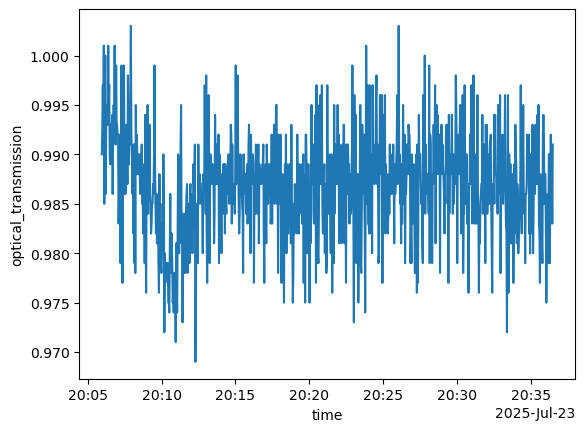

In [ ]:
lisst_ds.optical_transmission.plot()
plt.grid()
ax4 = plt.gca()
ax4.set_ylabel()
plt.title(" ".join(["Timeseries of ", ax4.get_ylabel()])+f"\n{fpath.split('\\')[-1][0:-4].replace("_", ".")}")
figname = "./figures/timeseries-"+fpath.split('\\')[-1]
# plt.savefig(figname.replace("csv", "png"))

In [8]:
# Calculate average percent optical transmission
lisst_ds.optical_transmission.mean().values*100

np.float64(98.68462377317339)

## Frequency-domain analysis

Compute the Welch PSD to examine the noise floor. 

In [9]:
# Define parameters for the PSD
dt = 2
fs = 1/dt
optical_transmission = lisst_ds.optical_transmission

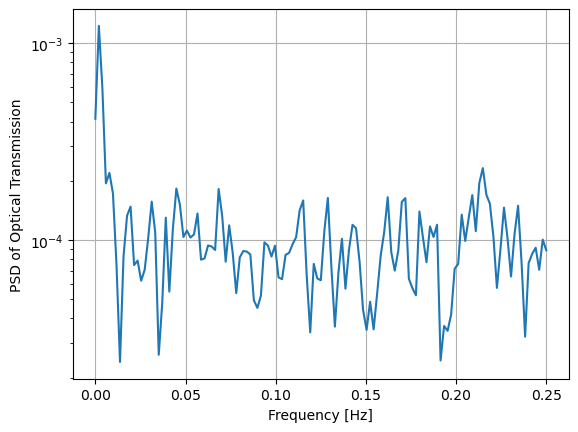

In [10]:
# Compute and plot the PSD
f, Pxx_OT = signal.welch(optical_transmission, fs)
plt.semilogy(f, Pxx_OT)
plt.xlabel("Frequency [Hz]")
plt.ylabel('PSD of Optical Transmission')
plt.grid()

# figname = "./figures/psd-"+fpath.split('\\')[-1]
# plt.savefig(figname.replace("csv", "png"))

## Particle size distribution

In [25]:
# prtsz2D.plot.pcolormesh()


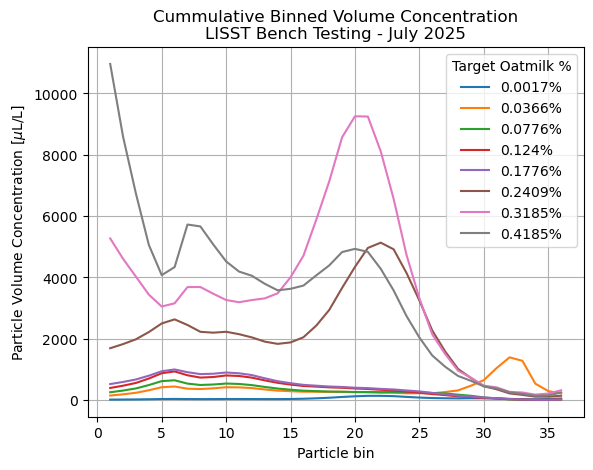

In [66]:
# Plot all of the cumulative binned volume concentrations on the same axes
def plot_summed_volumecon(data, axs, percent, norm=False):
    totalbins = data.volume_concentration_2D.sum(dim="time")
    if norm is True:
        # Normalize the cummulative binned volume concentrations
        totalbins = np.array(totalbins.values).reshape(1, -1)
        totalbins_norm = preprocessing.normalize(totalbins)
        # print(totalbins_norm.squeeze())
        bins = np.array(data.bin.values)
        axs.plot(bins, totalbins_norm.squeeze(), label=str(percent)+"%")
    else:
        totalbins.plot(ax=axs, label=str(percent)+"%")
    return axs

# Plot cummulative particle volume concentration by size bin
fig5, ax5 = plt.subplots()
# Add one line for each oatmilk concentration
ax5 = plot_summed_volumecon(lisst0017, ax5, 0.0017)
ax5 = plot_summed_volumecon(lisst0366, ax5, 0.0366)
ax5 = plot_summed_volumecon(lisst0776, ax5, 0.0776)
ax5 = plot_summed_volumecon(lisst1240, ax5, 0.1240)
ax5 = plot_summed_volumecon(lisst1776, ax5, 0.1776)
ax5 = plot_summed_volumecon(lisst2409, ax5, 0.2409)
ax5 = plot_summed_volumecon(lisst3185, ax5, 0.3185)
ax5 = plot_summed_volumecon(lisst4185, ax5, 0.4185)

plt.title("Cummulative Binned Volume Concentration\nLISST Bench Testing - July 2025")
ax5.set_ylabel(f"Particle Volume Concentration [{lisst4185.volume_concentration_2D.units}]")
ax5.set_xlabel("Particle bin")
ax5.legend(title="Target Oatmilk %")
ax5.grid()

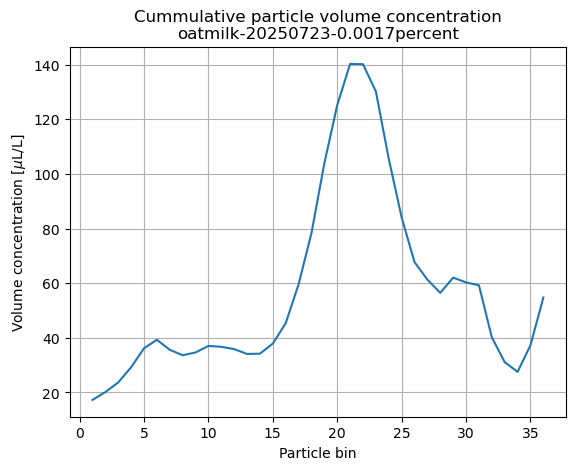

In [ ]:
# Plot cummulative particle volume concentration by size bin
fig, ax = plt.subplots()
totalbins = prtsz2D.sum(dim="time")
totalbins.plot(ax=ax)
plt.title(" ".join(["Cummulative", ax.get_ylabel()])+f"\n{fpath.split('\\')[-1][0:-4].replace("_", ".")}")
ax.set_ylabel(f"Volume concentration [{prtsz2D.units}]")
ax.set_xlabel("Particle bin")
ax.grid()

figname = "./figures/particle_volume-"+fpath.split('\\')[-1]
# plt.savefig(figname.replace("csv", "png"))

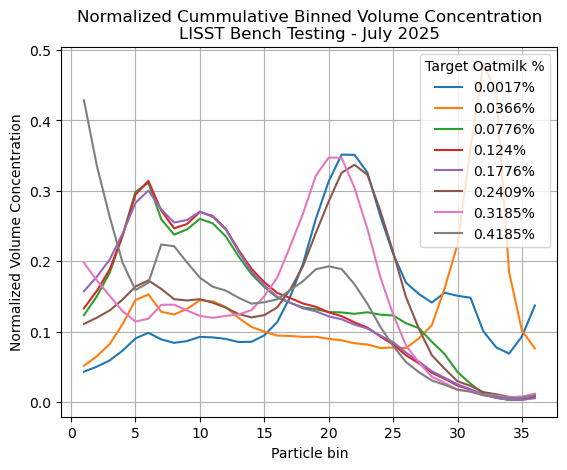

In [67]:
# Plot normalized cummulative particle volume concentration
fig5, ax5 = plt.subplots()
# Add one line for each oatmilk concentration
ax5 = plot_summed_volumecon(lisst0017, ax5, 0.0017, norm=True)
ax5 = plot_summed_volumecon(lisst0366, ax5, 0.0366, norm=True)
ax5 = plot_summed_volumecon(lisst0776, ax5, 0.0776, norm=True)
ax5 = plot_summed_volumecon(lisst1240, ax5, 0.1240, norm=True)
ax5 = plot_summed_volumecon(lisst1776, ax5, 0.1776, norm=True)
ax5 = plot_summed_volumecon(lisst2409, ax5, 0.2409, norm=True)
ax5 = plot_summed_volumecon(lisst3185, ax5, 0.3185, norm=True)
ax5 = plot_summed_volumecon(lisst4185, ax5, 0.4185, norm=True)

plt.title("Normalized Cummulative Binned Volume Concentration\nLISST Bench Testing - July 2025")
ax5.set_ylabel(f"Normalized Volume Concentration")
ax5.set_xlabel("Particle bin")
ax5.legend(title="Target Oatmilk %")
ax5.grid()